In [3]:
import SimpleITK as sitk
import numpy as np
import os
import time

from print_plot_routines import plti

In [5]:
# pathname = '/Users/john/Programming/Work/AnnotatedScans/scans/'
#inputPath  = '/Users/john/Programming/Work/AnnotatedScans/consensusAnnotations/'
#outputPath = '/Users/john/Programming/Work/AnnotatedScans/consensusDICOM/'
inputPath = '/Users/john/Downloads/Test Lung CTs- 45_115_562/45/'
outputPath = '/Users/john/Downloads/Test Lung CTs- 45_115_562/45/'

# inputPath  = '/Users/john/Programming/Work/AnnotatedScans/scans/'
# outputPath = '/Users/john/Programming/Work/AnnotatedScans/scansDICOM/'


## Helper Files

#### File handling


`load_itk` - reads an '.mhd' file using SimpleITK and returns the image array, origin, and spacing of the image.  
`load_scan2` - scans the provided directory and returns a list of all files with the provided extension.

In [6]:
'''
This funciton reads a '.mhd' file using SimpleITK and return the image array, origin and spacing of the image.
'''

def load_itk(filename):
    # Reads the image using SimpleITK
    itkimage = sitk.ReadImage(filename)

    # Convert the image to a  numpy array first and then shuffle the dimensions to get axis in the order z,y,x
    ct_scan = sitk.GetArrayFromImage(itkimage)

    # Read the origin of the ct_scan, will be used to convert the coordinates from world to voxel and vice versa.
    origin = np.array(list(reversed(itkimage.GetOrigin())))

    size = itkimage.GetSize()
    
    # Read the spacing along each dimension
    spacing = itkimage.GetSpacing()

    return ct_scan, origin, spacing, size, itkimage

In [7]:
def load_scan2(path,ext='.mhd'):
    
    lstFilesDCM = []

    for dirName, subdirList, fileList in os.walk(path):
        for filename in fileList:
            if ext in filename.lower():
                lstFilesDCM.append(os.path.join(dirName,filename))

    lstFilesDCM.sort()
    return lstFilesDCM


In [8]:
def padStack(image,padding):
    
    nImage = sitk.GetArrayFromImage(image)
    slice = nImage[0,:,:]

#     print('Original Size (nImage): = {}'.format(nImage.shape))

    xDelta = 512-slice.shape[0]
    xLAdd = int(np.ceil(xDelta/2))
    xRAdd = int(np.floor(xDelta/2))

    yDelta = 512-slice.shape[1]
    yLAdd = int(np.ceil(yDelta/2))
    yRAdd = int(np.floor(yDelta/2))

    pImage = np.lib.pad(nImage, ((0,0),(xLAdd,xRAdd),(yLAdd,yRAdd)), 'constant',constant_values=padding)
    image = sitk.GetImageFromArray(pImage)

#    print(pImage[0:10,0:10,0])
#     print('Final size: {}'.format(image.GetSize()))

    return image


In [9]:
def writeSlices(series_tag_values, new_img, i, outputPath, filename):
    image_slice = new_img[:,:,i]

    # Tags shared by the series.
    list(map(lambda tag_value: image_slice.SetMetaData(tag_value[0], tag_value[1]), series_tag_values))

    # Slice specific tags.
#     image_slice.SetMetaData("0008|0012", time.strftime("%Y%m%d")) # Instance Creation Date
#     image_slice.SetMetaData("0008|0013", time.strftime("%H%M%S")) # Instance Creation Time

    # (0020, 0032) image position patient determines the 3D spacing between slices.
    image_slice.SetMetaData("0020|0032", '\\'.join(map(str,new_img.TransformIndexToPhysicalPoint((0,0,i))))) # Image Position (Patient)
    image_slice.SetMetaData("0020|0013", str(i)) # Instance Number

    # Write to the output directory and add the extension dcm, to force writing in DICOM format.
    writer = sitk.ImageFileWriter()
    # Use the study/series/frame of reference information given in the meta-data
    # dictionary and not the automatically generated information from the file IO
    writer.KeepOriginalImageUIDOn()
    
    writer.SetFileName(os.path.join(outputPath,os.path.basename(filename)+'-'+str(i)+'.dcm'))
    writer.Execute(image_slice)


In [10]:
def writeDICOM(image, outputPath, filename,patName,seriesUID,seriesDescription):
    modification_time = time.strftime("%H%M%S")
    modification_date = time.strftime("%Y%m%d")

    direction = image.GetDirection()
    
    parts = filename.split('.')
    description = parts[6]+'_'+ parts[-2].split('_')[-1]

    series_tag_values = [
                        ("0008|0008","DERIVED\\SECONDARY"), # Image Type
                        ("0008|0021",modification_date),    # Series Date
                        ("0008|0031",modification_time),    # Series Time
                        ("0008|0060", "CT"),                # Type to CT 
                        ("0008|1030", description),         # Series Description
                        ("0008|103e", "Created-SimpleITK"), # Series Description
                        ("0010|0010", patName),             # Patient Name
                        ("0010|0020", str(parts[6])),       # Patient ID
                        ("0018|0050", str(image.GetSpacing()[2])), # Series Description
                        ("0018|1030", seriesDescription),   # Series Description
                        ("0020|000d", "1"),                 # Study Instance UID
                        ("0020|000e", seriesUID+modification_date+".1"+modification_time), # Series Instance UID
                        ("0020|0010", "123456"),            # Study #
                        ("0020|0011", "123456"),            # Series #
                        ("0020|0037", '\\'.join(map(str, (direction[0], direction[3], direction[6],# Image Orientation (Patient)
                                                        direction[1],direction[4],direction[7]))))
                        ] 

    # Write slices to output directory
    err = list(map(lambda i: writeSlices(series_tag_values, image, i,outputPath,description), range(image.GetDepth())))



## Manipulation Routines

This code gets a list of mhd files and then prints the dimensions and pixel size of each

In [11]:
filelist = load_scan2(inputPath)

print('Total Files Found: {}\n'.format(len(filelist)))
print('    Dimensions         size                filename')
print("-" * 17,"-" * 15,' '*3,'-'*40)

i = 0 # Enables padding on specified file
j = 0 # Enables saving on specified file
for filename in filelist:
    scan, origin, spacing, size, image = load_itk(filename)
    shortname = filename.replace(inputPath,'')

    print('{:5.3f} {:5.3f} {:5.3f} {:4d} {:4d} {:4d}      {}'.format(*spacing,*size,shortname))
    
    if i < 1:
        dScan = padStack(image,-2048)
        dScan.SetSpacing(spacing)
#         print(scan.shape,dScan.GetSize())
        i += 1

    if j < 1:
        patientName = 'CARVE 12'
        seriesUID = "1.2.826.0.1.3680043.2.1125."
        seriesDescrip = 'Padded to 512x512'
        writeDICOM(dScan,outputPath,filename,patientName,seriesUID,seriesDescrip)
        j = 1



Total Files Found: 1

    Dimensions         size                filename
----------------- ---------------     ----------------------------------------


RuntimeError: Exception thrown in SimpleITK ImageFileReader_Execute: /Users/runner/work/1/sitk/Code/IO/src/sitkImageReaderBase.cxx:105:
sitk::ERROR: Unable to determine ImageIO reader for "/Users/john/Downloads/Test Lung CTs- 45_115_562/45/ctvolume.mhd"

This code prints the size of the currently loaded DICOM stack and then a slice from that stack.

1.2.840.113704.1.111.1068.1103364672_consensusAnnotations.mhd
(409, 314, 472)
(314, 472)


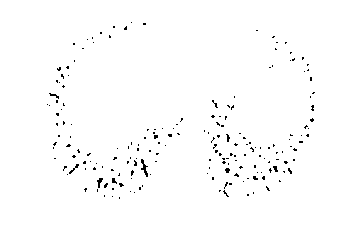

In [90]:
printSlice = 87

print(filename)
print(scan.shape)
plti(scan[printSlice,:,:])
print(scan[printSlice,:,:].shape)

    Dimensions         size                filename
----------------- ---------------     ----------------------------------------
('ITK_InputFilterName',)
0.703 0.703 0.700  472  314  409      1.2.840.113704.1.111.1068.1103364672_consensusAnnotations.mhd
[[0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
depth: 409
size: (512, 512, 409)
spacing: (0.703125, 0.703125, 0.7)
direction: (1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0)
thickness: 0.7


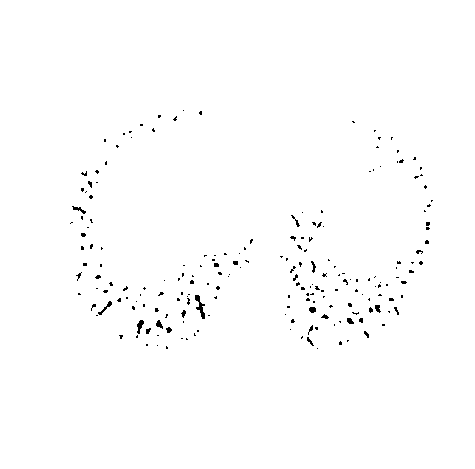

In [11]:
# pathname = '/Users/john/Programming/Work/AnnotatedScans/scans/'
pathname = '/Users/john/Programming/Work/AnnotatedScans/consensusAnnotations/'

filename = '1.2.840.113704.1.111.1068.1103364672_consensusAnnotations.mhd'

print('    Dimensions         size                filename')
print("-" * 17,"-" * 15,' '*3,'-'*40)

scan, origin, spacing, size, image = load_itk(pathname + filename)
shortname = filename.replace(pathname,'')

print(image.GetMetaDataKeys())
print('{:5.3f} {:5.3f} {:5.3f} {:4d} {:4d} {:4d}      {}'.format(*spacing,*size,shortname))

image = padStack(image,0)
image.SetSpacing(spacing)

pSlice = sitk.GetArrayFromImage(image[:,:,87])
plti(pSlice)
print('depth: {}'.format(image.GetDepth()))
print('size: {}'.format(image.GetSize()))
print('spacing: {}'.format(image.GetSpacing()))
print('direction: {}'.format(image.GetDirection()))
print('thickness: {}'.format(str(image.GetSpacing()[2])))

In [171]:
modification_time = time.strftime("%H%M%S")
modification_date = time.strftime("%Y%m%d")

direction = image.GetDirection()

parts = filename.split('.')
description = parts[6]+'_'+ parts[-2].split('_')[-1]

series_tag_values = [("0008|0031",modification_time), # Series Time
                  ("0008|0021",modification_date), # Series Date
                  ("0008|0008","DERIVED\\SECONDARY"), # Image Type
                  ("0020|000e", "1.2.826.0.1.3680043.2.1125."+modification_date+".1"+modification_time), # Series Instance UID
                  ("0020|0037", '\\'.join(map(str, (direction[0], direction[3], direction[6],# Image Orientation (Patient)
                                                    direction[1],direction[4],direction[7])))),
                  ("0008|1030", description), # Series Description
                  ("0008|103e", "Created-SimpleITK")] # Series Description

# Write slices to output directory
err = list(map(lambda i: writeSlices(series_tag_values, image, i,pathname,filename), range(image.GetDepth())))


In [155]:
series_IDs = sitk.ImageSeriesReader.GetGDCMSeriesIDs(pathname)
if not series_IDs:
    print("ERROR: given directory \""+pathname+"\" does not contain a DICOM series.")
    sys.exit(1)
series_file_names = sitk.ImageSeriesReader.GetGDCMSeriesFileNames(pathname, series_IDs[0])

series_reader = sitk.ImageSeriesReader()
series_reader.SetFileNames(series_file_names)

# Configure the reader to load all of the DICOM tags (public+private):
# By default tags are not loaded (saves time).
# By default if tags are loaded, the private tags are not loaded.
# We explicitly configure the reader to load tags, including the
# private ones.
series_reader.LoadPrivateTagsOn()
image3D = series_reader.Execute()


(512, 512)
depth: 409
size: (512, 512, 409)
direction: (1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0)
spacing: (0.703125, 0.703125, 0.699999988079071)
origin: (0.0, 0.0, 0.0)


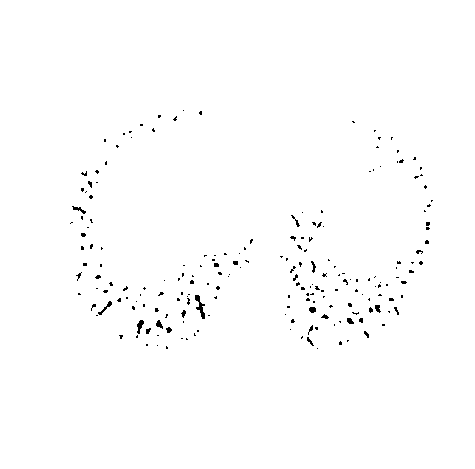

In [156]:
pSlice = sitk.GetArrayFromImage(image3D[:,:,87])

plti(pSlice)
print(pSlice.shape)
print('depth: {}'.format(image3D.GetDepth()))
print('size: {}'.format(image3D.GetSize()))
print('direction: {}'.format(image3D.GetDirection()))
print('spacing: {}'.format(image3D.GetSpacing()))
print('origin: {}'.format(image3D.GetOrigin()))

In [246]:
reader = sitk.ImageFileReader()

reader.SetFileName( filename )
reader.LoadPrivateTagsOn();

reader.ReadImageInformation();

for k in reader.GetMetaDataKeys():
    v = reader.GetMetaData(k)
    print("({0}) = = \"{1}\"".format(k,v))


(ITK_InputFilterName) = = "MetaImageIO"


In [244]:
img = sitk.ReadImage(inputPath + '1.2.840.113704.1.111.1068.1103364672.7.mhd')
print(img.GetMetaDataKeys())
print(type(img))
img.GetMetaData("0008|0008") // Modality


('ITK_InputFilterName',)
<class 'SimpleITK.SimpleITK.Image'>


RuntimeError: Exception thrown in SimpleITK Image_GetMetaData: /scratch/dashboard/SimpleITK-OSX10.6-x86_64-pkg/SimpleITK-build/ITK/Modules/Core/Common/src/itkMetaDataDictionary.cxx:88:
itk::ERROR: Key '0008|0008' does not exist 